In [2]:
import pandas as pd
import igraph as ig
import numpy as np
import leafmap
from pyproj import Transformer
import geopandas as gpd
from shapely.geometry import Point, LineString
import geopandas as gpd
import matplotlib.pyplot as plt
import fiona

In [3]:
# importing the data
df = pd.read_csv("E:/!!Research/!!!Data/graph_analysis/lek_data/lek_data_binary_rolling_activity.csv")

# dropping the column from the last time was exported
df.drop('Unnamed: 0', axis = 1, inplace = True)

df.head()

,lek_id,year,x_easting,y_northing,activity,active_last_5_years
0,2,1971,672527,3730500,not surveyed,Inactive or not surveyed
1,2,1972,672527,3730500,not surveyed,Inactive or not surveyed
2,2,1973,672527,3730500,not surveyed,Inactive or not surveyed
3,2,1974,672527,3730500,not surveyed,Inactive or not surveyed
4,2,1975,672527,3730500,not surveyed,Inactive or not surveyed


In [4]:
# filtering the data by year and by activity in the last five years
df_1990 = df[(df['year'] == 1990) & (df['active_last_5_years'] == 'TRUE')]
df_1990.head()

,lek_id,year,x_easting,y_northing,activity,active_last_5_years
451,4570,1990,609784,3699008,not surveyed,TRUE
499,4574,1990,599720,3696239,FALSE,TRUE
547,4575,1990,602100,3690464,not surveyed,TRUE
595,4576,1990,601500,3685734,not surveyed,TRUE
643,4577,1990,604825,3677086,not surveyed,TRUE


In [5]:
# Initializing the graph
g = ig.Graph()

# Adding vertices using 'lek_id' as the vertex name
g.add_vertices(df_1990['lek_id'].tolist())

Manually determining link distance

In [6]:
# Define a threshold distance (e.g., in meters)
threshold_distance = 30000  # Adjust as needed

# Create a lookup dictionary for lek_id to vertex index
lek_id_to_index = {name: idx for idx, name in enumerate(g.vs["name"])}

for i in range(len(df_1990)):
    for j in range(i + 1, len(df_1990)):
        # Calculate Euclidean distance
        easting_diff = df_1990.iloc[i]['x_easting'] - df_1990.iloc[j]['x_easting']
        northing_diff = df_1990.iloc[i]['y_northing'] - df_1990.iloc[j]['y_northing']
        distance = np.sqrt(easting_diff**2 + northing_diff**2)

        # Add edge if within threshold, using vertex indices
        if distance <= threshold_distance:
            g.add_edge(lek_id_to_index[df_1990.iloc[i]['lek_id']], lek_id_to_index[df_1990.iloc[j]['lek_id']])

# Print graph info and visualize
#print(g)

Binary search tree to automatically find coalescence distance

In [7]:
# List to hold all pairwise distances
distances = []

# Calculate all pairwise distances
for i in range(len(df_1990)):
    for j in range(i + 1, len(df_1990)):
        easting_diff = df_1990.iloc[i]['x_easting'] - df_1990.iloc[j]['x_easting']
        northing_diff = df_1990.iloc[i]['y_northing'] - df_1990.iloc[j]['y_northing']
        distance = np.sqrt(easting_diff**2 + northing_diff**2)
        distances.append(distance)

# Sort distances
distances.sort()

# Function to check if the graph is connected for a given threshold
def is_connected(threshold):
    g_temp = ig.Graph()
    g_temp.add_vertices(len(df_1990))
    g_temp.vs["name"] = df_1990['lek_id'].tolist()

    for i in range(len(df_1990)):
        for j in range(i + 1, len(df_1990)):
            easting_diff = df_1990.iloc[i]['x_easting'] - df_1990.iloc[j]['x_easting']
            northing_diff = df_1990.iloc[i]['y_northing'] - df_1990.iloc[j]['y_northing']
            distance = np.sqrt(easting_diff**2 + northing_diff**2)

            if distance <= threshold:
                g_temp.add_edge(i, j)

    return g_temp.is_connected(), g_temp

# Binary search for the minimum threshold distance
low, high = 0, len(distances) - 1
result = -1  # Default if no threshold found
final_graph = None

while low <= high:
    mid = (low + high) // 2
    threshold_distance = distances[mid]

    connected, temp_graph = is_connected(threshold_distance)
    if connected:
        result = threshold_distance  # Update result
        final_graph = temp_graph  # Store the final graph
        high = mid - 1  # Try for a smaller threshold
    else:
        low = mid + 1  # Increase threshold

Exporting a shapefile of the final coalescence distance edges

In [ ]:
if result != -1:
    print(f"Threshold distance to connect all leks: {result} meters")
else:
    print("No threshold distance found that connects all leks.")

Threshold distance to connect all leks: 23093.276099332463 meters


In [9]:
# Prepare edges for exporting
edges_data = []
for edge in final_graph.get_edgelist():
    lek1_index, lek2_index = edge
    lek1 = df_1990.iloc[lek1_index]
    lek2 = df_1990.iloc[lek2_index]
    
    # Create a line geometry for the edge
    line_geom = LineString([(lek1['x_easting'], lek1['y_northing']),
                            (lek2['x_easting'], lek2['y_northing'])])
    
    # Calculate the length of the edge
    edge_length = line_geom.length  # This gives the length in the same units as your coordinates (meters)

    # Append the geometry and length to the edges data
    edges_data.append({'geometry': line_geom, 'lek1': lek1['lek_id'], 'lek2': lek2['lek_id'], 'length': edge_length})

# Create a GeoDataFrame
edges_gdf = gpd.GeoDataFrame(edges_data, crs='EPSG:32613')  # Set the appropriate CRS for UTM 13N

# Export to shapefile
def edge_shp_export(given_gdf, given_path):
    given_gdf.to_file(given_path, driver='ESRI Shapefile')
    print('edges exported to shapefile')
edge_shp_export(edges_gdf, "E:/!!Research/!!!Data/graph_analysis/spatial_data/yearly_coalescence_edges/lek_connections.shp")
#edges_gdf.to_file("E:/!!Research/!!!Data/graph_analysis/spatial_data/yearly_coalescence_edges/lek_connections.shp", driver='ESRI Shapefile')

edges exported to shapefile


In [39]:
ebs = g.edge_betweenness()
max_eb = max(ebs)
[g.es[idx].tuple for idx, eb in enumerate(ebs) if eb == max_eb]

[(85, 108)]

In [42]:
#g.layout(layout='auto')
#ig.plot(g)

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString

# Convert DataFrame to GeoDataFrame
gdf_points = gpd.GeoDataFrame(df_1990, geometry=gpd.points_from_xy(df_1990['x_easting'], df_1990['y_northing']))
gdf_points.set_crs("EPSG:26913", inplace=True)  # NAD83 / UTM zone 13N

# Create edges based on graph structure
edges = []
for edge in g.es:
    source = edge.source
    target = edge.target
    point1 = gdf_points.iloc[source].geometry
    point2 = gdf_points.iloc[target].geometry
    edges.append(LineString([point1, point2]))

# Convert edges to a GeoDataFrame
gdf_edges = gpd.GeoDataFrame(geometry=edges)
gdf_edges.set_crs("EPSG:26913", inplace=True)

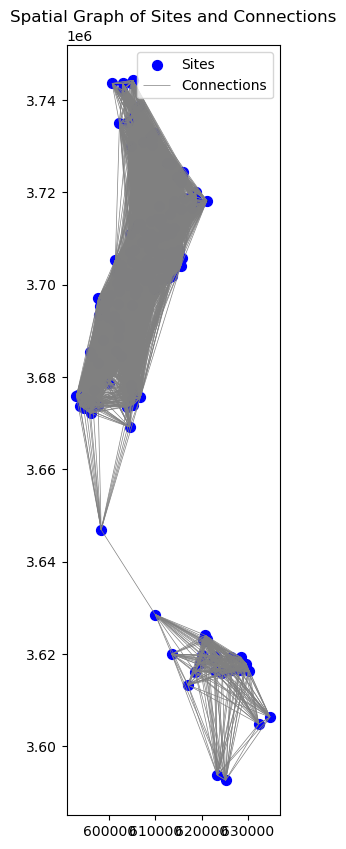

In [ ]:
# Plot map
fig, ax = plt.subplots(figsize=(10, 10))
gdf_points.plot(ax=ax, color='blue', markersize=50, label="Leks")
gdf_edges.plot(ax=ax, color='gray', linewidth=0.5, label="Connections")

# Adding title and legend
plt.title("Map of leks and connections")
plt.legend()
plt.show()